In [53]:
import matplotlib.pyplot as plt
import torchvision.datasets as dts
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
from typing import Tuple, List
import os
import random
from torch.utils.data import DataLoader



#all imports required

## Importing Dataset and Loading Data using DataLoader

In [65]:

class CatsDogsDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.path = list(Path(self.root_dir).glob("**/*.jpg"))
        self.transform = transform
        self.classes, self.classes_to_idx = self.__find_classes()

    def __getitem__(self, index) -> Tuple[Image.Image, int]:
        image = self.__load_image(index)
        class_name = self.__get_class(index)
        class_idx = self.classes_to_idx[class_name]
        
        if self.transform:
            image = self.transform(image)

        return image, class_idx

    def __len__(self) -> int:
        return len(self.path)

    def __find_classes(self) -> Tuple[List[str], dict]:
        classes = sorted(entry.name for entry in os.scandir(self.root_dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def __load_image(self, index: int) -> Image.Image:
        return Image.open(self.path[index]).convert("RGB")
    
    def __get_class(self, index: int) -> str:
        return self.path[index].parent.name
    
    
train_transforms = transforms.Compose([
transforms.Resize(size=(224,224)),
transforms.RandomRotation(90),
transforms.ToTensor(),
transforms.Normalize(std=(0.5,0.5,0.5),mean=(0.5,0.5,0.5))
])

    
test_transforms= transforms.Compose([
transforms.Resize(size=(224,224)),
transforms.Normalize(std=(0.5,0.5,0.5),mean=(0.5,0.5,0.5)),
transforms.ToTensor()
])




In [66]:

train_cd = CatsDogsDataset(root_dir="data/train", transform= train_transforms)
test_cd = CatsDogsDataset(root_dir="data/test", transform = test_transforms)

#len(train_cd), len(test_cd)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


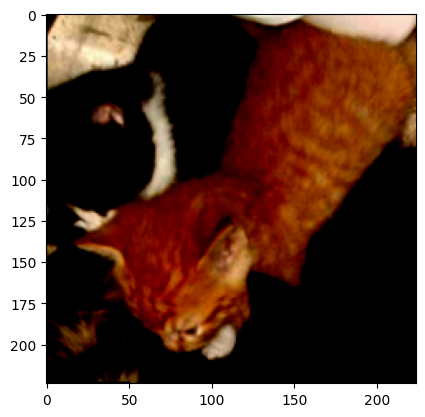

In [77]:
train_loader = DataLoader(train_cd, batch_size=32, shuffle=True)
test_loader = DataLoader(test_cd, batch_size=32, shuffle=False)
data_iterator = iter(train_loader)
images, labels = next(data_iterator)
image = random.choice(images)

plt.imshow(image.permute(1, 2, 0))
# idx = random.sample(range(len(train_cd)), k=1)
# data: Tuple[Image.Image, int] = train_cd[idx[0]]
# image, target = data
# plt.imshow(image)
# plt.title(f"Class: {train_cd.classes[target]} | Shape {image.size}")


## Creating Binary Classification Model 

In [81]:
#setting up device to be on gpu for running train (ahead)
device = "cuda" if torch.cuda.is_available() else "cpu"

#creating Model
class BC_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(224*224*3, 100) 
        self.fc2 = nn.Linear(100, 160)
        self.fc3 = nn.Linear(160, 1)

    def forward(self, xb):
        xb = xb.reshape(-1, 224*224*3) 
        out = self.fc1(xb)
        out = F.sigmoid(out)
        out = self.fc2(out)
        out = F.sigmoid(out)
        out = self.fc3(out)
        return out

In [82]:
#model's hyperparameters 
model_0 = BC_Model()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

## Training the Model

In [83]:

def train( model, train_loader,test_loader, loss_function, optimizer,epochs,):
        epochs_count, train_losses, test_losses = [], [], []
        for epoch in range(epochs):
                model.train()
                for images, labels in train_loader:
                        optimizer.zero_grad()
                        output_pred = model(images)

                        train_loss = loss_function(output_pred, labels)
                        train_loss.backward()
                        optimizer.step()
             
                model.eval()
                for images, labels in test_loader:
                        output_pred = model(images)
                        test_loss = loss_function(output_pred, labels)
                if epoch % 10 == 0:
                        epochs_count.append(epoch)
                        train_losses.append(train_loss.detach().numpy())
                        test_losses.append(test_loss.detach().numpy())
                        print(f'Epoch {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
        return epochs_count, train_losses, test_losses



In [ ]:
epochs_count, train_losses, test_losses = train(model_0, train_loader, test_loader, loss_function, optimizer, epochs=10)
## to be trained in googlecollab

## Model predictions

In [85]:
def predict(model, data):
    model.eval()
    with torch.inference_mode():
        output = model(data)
        predicted = torch.softmax(output, dim=1).argmax(dim=1)
        return predicted


In [ ]:
images, labels = next(iter(test_loader))

plt.figure(figsize=(15,10))
for i in range(25):
    image = images[i]
    label = labels[i]
    prediction = predict(model_0, image).item()
    color = 'green' if label ==prediction else 'red'
    plt.subplot(5,5,i+1)
    plt.imshow(image.numpy().squeeze(), cmap = 'gray')
    plt.axis('off')
    plt.title(f'Actual: {label}| Prediction: {prediction}', color = color)
plt.show()

## Creating CNN Model 

In [87]:
class CNNModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.conv1_layer = nn.Sequential(
       nn.Conv2d(3,128,3,stride=1,padding='same'),
       nn.ReLU(), 
       nn.MaxPool2d(3)
    )
    self.conv2_layer=nn.Sequential(
      nn.Conv2d(128,256,5, stride = 1, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(5)
    )
    self.conv3_layer=nn.Sequential(
      nn.Conv2d(256,128,3, stride = 1, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(3)
    )
    self.linear_layer = nn.Sequential(
            nn.Linear(in_features=224*224*3, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=160),
            nn.ReLU(),
            nn.Linear(in_features=160, out_features=1)
        )
  def forward(self,x:torch.Tensor):
    batch_size = x.shape[0]
    y = self.conv1_layer(x)
    y =self.conv2_layer(y)
    y= self.conv3_layer(y)
    y = y.view(1, -1)
    y = self.linear_layer(y)
    return y
  
model_1= CNNModel()

In [ ]:
epochs_count, train_losses, test_losses = train(model_1, train_loader, test_loader, loss_function, optimizer, epochs=10)
## to be trained in googlecollab using same train function as above 

In [ ]:
#predicting values using same function as above

images, labels = next(iter(test_loader))

plt.figure(figsize=(15,10))
for i in range(25):
    image = images[i]
    label = labels[i]
    prediction = predict(model_1, image).item()
    color = 'green' if label ==prediction else 'red'
    plt.subplot(5,5,i+1)
    plt.imshow(image.numpy().squeeze(), cmap = 'gray')
    plt.axis('off')
    plt.title(f'Actual: {label}| Prediction: {prediction}', color = color)
plt.show()

## to be tested